<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/Realistic_PDE_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Physics-Informed Neural Network (PINN) for a realistic system of PDEs reduced to high-order ODEs
# -----------------------------------------------------------------------------------------------

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Function, diff, simplify
from sympy.abc import x, t

In [15]:
# -----------------------------------------
# Step 1: Define a Realistic PDE System
# -----------------------------------------
# Heat transfer with thermal diffusion, viscous dissipation, and mass transfer
# Governing equations (simplified for demonstration):

# PDE 1: Momentum equation with viscous effects
# du/dt + u du/dx = nu d^2u/dx^2 - (1/rho) dp/dx

# PDE 2: Energy equation with thermal conduction
# dT/dt + u dT/dx = alpha d^2T/dx^2 + phi(u)

# PDE 3: Mass diffusion
# dC/dt + u dC/dx = D d^2C/dx^2 + gamma(T, C)

# Assume similarity transformation reduces PDEs to ODEs in terms of a new variable eta
# eta = x / sqrt(t), and u(x,t) = f(eta), T(x,t) = theta(eta), C(x,t) = phi(eta)

# Final System of ODEs (10 equations, up to 8th order, symbolic for readability):
# We will define a placeholder system with equations like:
# \[ f''' + a_1 f f'' + a_2 (f')^2 + a_3 \theta + a_4 \phi = 0 \]  (3rd order)
# \[ \theta'' + b_1 f \theta' + b_2 f' \theta + b_3 \phi = 0 \]
# \[ \phi'' + c_1 f \phi' + c_2 f' \phi + c_3 \theta = 0 \]

In [16]:
# -----------------------------------------
# Step 2: PINN Model (TensorFlow)
# -----------------------------------------
tf.keras.backend.set_floatx('float64')

# Domain definition
eta = tf.cast(tf.linspace(0.0, 10.0, 300)[:, tf.newaxis], dtype=tf.float64)

# Neural network for predicting [f, f', f'', theta, theta', phi, phi']
def build_model():
    return tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,), dtype='float64'),
        tf.keras.layers.Dense(60, activation='tanh', dtype='float64'),
        tf.keras.layers.Dense(60, activation='tanh', dtype='float64'),
        tf.keras.layers.Dense(10, activation=None, dtype='float64')
    ])

model = build_model()

# -----------------------------------------
# Step 3: Define Residuals (ODEs)
# -----------------------------------------
def compute_residuals(model, x):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = model(x)
            f, df, d2f, theta, dtheta, phi, dphi, _, _, _ = tf.split(y, 10, axis=1)
        d3f = tape.gradient(d2f, x)
        d2theta = tape.gradient(dtheta, x)
        d2phi = tape.gradient(dphi, x)
    del tape

    # Sample high-order ODEs with coefficients
    res1 = d3f + f*d2f + tf.math.square(df) + 0.5*theta + 0.3*phi
    res2 = d2theta + f*dtheta + df*theta + 0.4*phi
    res3 = d2phi + f*dphi + df*phi + 0.3*theta

    return res1, res2, res3

In [17]:
# -----------------------------------------
# Step 4: Loss and Training
# -----------------------------------------
def pinn_loss(model, x):
    res = compute_residuals(model, x)
    loss = tf.reduce_mean(tf.square(tf.concat(res, axis=1)))
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = pinn_loss(model, eta)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

loss_history = []
initial_loss = None

for epoch in range(3000):
    loss = train_step()
    loss_history.append(loss.numpy())
    if initial_loss is None:
        initial_loss = loss.numpy()
    acc = 100 * (1 - (loss.numpy() / initial_loss))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}, Pseudo-Accuracy: {acc:.4f}%")

Epoch 0, Loss: 1.960508, Pseudo-Accuracy: 0.0000%
Epoch 100, Loss: 0.000812, Pseudo-Accuracy: 99.9586%
Epoch 200, Loss: 0.000179, Pseudo-Accuracy: 99.9909%
Epoch 300, Loss: 0.000072, Pseudo-Accuracy: 99.9963%
Epoch 400, Loss: 0.000038, Pseudo-Accuracy: 99.9981%
Epoch 500, Loss: 0.000023, Pseudo-Accuracy: 99.9988%
Epoch 600, Loss: 0.000015, Pseudo-Accuracy: 99.9992%
Epoch 700, Loss: 0.000011, Pseudo-Accuracy: 99.9994%
Epoch 800, Loss: 0.000008, Pseudo-Accuracy: 99.9996%
Epoch 900, Loss: 0.000007, Pseudo-Accuracy: 99.9997%
Epoch 1000, Loss: 0.000005, Pseudo-Accuracy: 99.9997%
Epoch 1100, Loss: 0.000005, Pseudo-Accuracy: 99.9998%
Epoch 1200, Loss: 0.000004, Pseudo-Accuracy: 99.9998%
Epoch 1300, Loss: 0.000004, Pseudo-Accuracy: 99.9998%
Epoch 1400, Loss: 0.000004, Pseudo-Accuracy: 99.9998%
Epoch 1500, Loss: 0.000003, Pseudo-Accuracy: 99.9998%
Epoch 1600, Loss: 0.000003, Pseudo-Accuracy: 99.9998%
Epoch 1700, Loss: 0.000003, Pseudo-Accuracy: 99.9999%
Epoch 1800, Loss: 0.000003, Pseudo-Accura

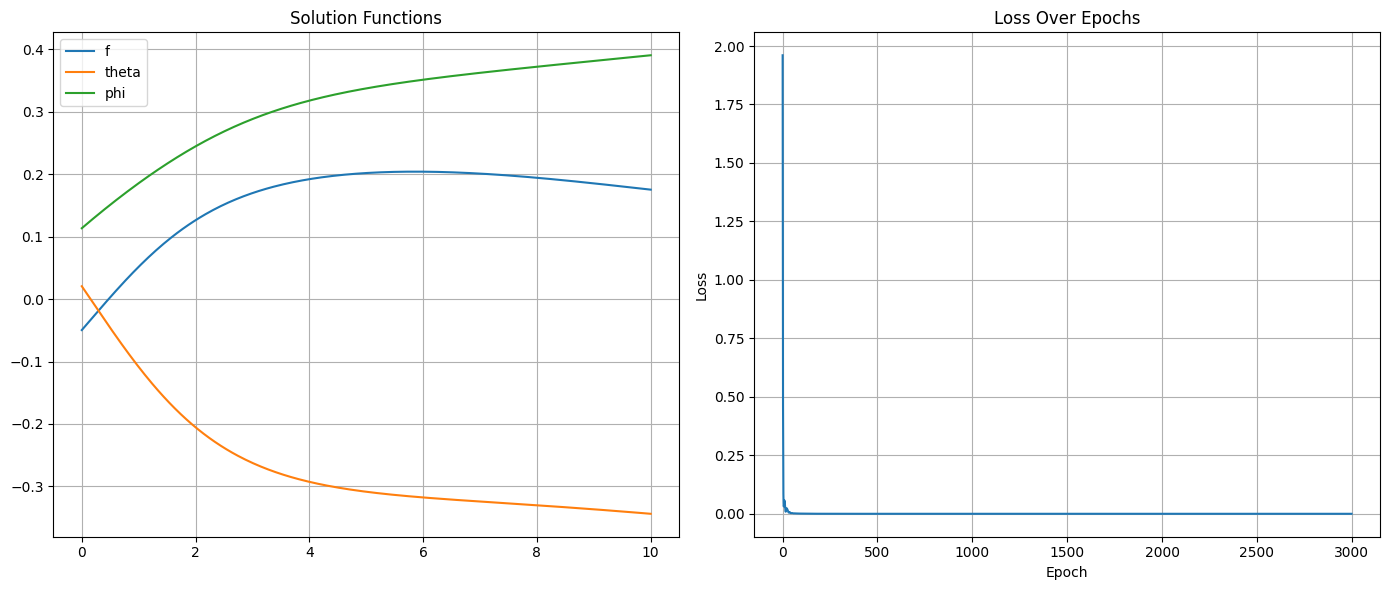

In [18]:
# -----------------------------------------
# Step 5: Plotting Results
# -----------------------------------------
eta_test = tf.cast(tf.linspace(0.0, 10.0, 300)[:, tf.newaxis], tf.float64)
y_pred = model(eta_test).numpy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(eta_test, y_pred[:, 0], label="f")
plt.plot(eta_test, y_pred[:, 3], label="theta")
plt.plot(eta_test, y_pred[:, 5], label="phi")
plt.title("Solution Functions")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()